<a href="https://colab.research.google.com/github/grazder/dul_2021/blob/hw1/Homework1_MADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 100 (delta 32), reused 55 (delta 14), pack-reused 0
Receiving objects: 100% (100/100), 26.18 MiB | 35.18 MiB/s, done.
Resolving deltas: 100% (32/32), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul_202

In [2]:
from dul_2021.utils.hw1_utils import *

In [3]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

# MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


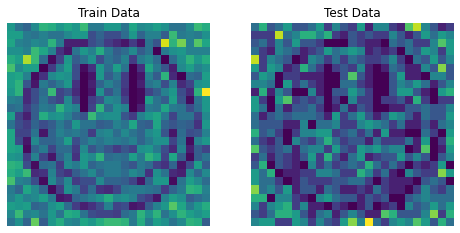

Dataset 2


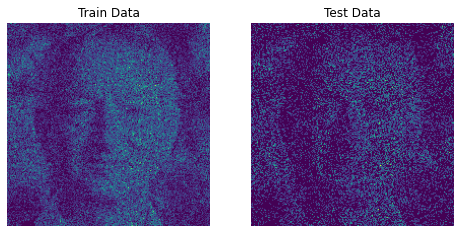

In [4]:
visualize_q1a_data(dset_type=1)
visualize_q1a_data(dset_type=2)
# you can access data with get_data_q1_a(dset_type=1)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [5]:
from torch import nn

# MaskedLinear from practice
class MaskedLinear(nn.Linear):    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class MADE(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, hidden_size, num_classes):
        super().__init__()
        self._input_dim = input_dim
        self._output_dim = output_dim
        self._num_layers = num_layers
        self._num_classes = num_classes
        self._hidden_sizes = self._num_layers * [hidden_size]
        self._masks = {}
        
        layers = []
        sizes = [self._input_dim * self._num_classes] + self._hidden_sizes + [self._output_dim * self._num_classes] 

        for i in range(len(sizes) - 1):
            layers += [
                MaskedLinear(sizes[i], sizes[i + 1]),
                nn.ReLU()
            ]
        
        layers = layers[:-1]

        self.made = nn.Sequential(*layers)
        self.make_masks()

    def make_masks(self):
        self._masks[-1] = np.repeat(np.arange(self._input_dim), self._num_classes) # or some other odering
        
        for l in range(self._num_layers):
            self._masks[l] = np.random.randint(self._masks[l - 1].min(), self._input_dim - 1, size=self._hidden_sizes[l])

        masks = [self._masks[layer_i - 1][:,None] <= self._masks[layer_i][None,:] for layer_i in range(self._num_layers)]
        masks.append(self._masks[self._num_layers - 1][:, None] < self._masks[-1][None, :])
        
        # set mask for each masked Linear layer
        layers = [layer_i for layer_i in self.made.modules() if isinstance(layer_i, MaskedLinear)]
        for layer, mask in zip(layers, masks):
            layer.set_mask(mask)

    def forward(self, x):
        model_out = self.made(x.reshape(-1, self._output_dim * self._num_classes))
        reshaped_out = model_out.reshape(-1, self._output_dim, self._num_classes)
        return reshaped_out

In [6]:
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import one_hot
from itertools import product


def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """
    
    batch_losses = []
    epoch_losses = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train = torch.from_numpy(train_data)
    test = torch.from_numpy(test_data)

    model = MADE(train.shape[1], train.shape[1], 3, 64, d).to(device)

    N_EPOCH = 100
    BATCH_SIZE = 1024

    def collate_fn(x):
        coords = [sample[0] for sample in x]
        batch_list = [one_hot(sample, d).float() for sample in coords]
        return torch.stack(batch_list).to(device), torch.stack(coords).to(device)

    train_dataset = TensorDataset(train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    test_dataset = TensorDataset(test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    opt = torch.optim.Adam(model.parameters(), 1e-3)

    for n_epoch in range(N_EPOCH):
        # valid_part
        model.eval()
        eval_losses = []

        for batch, coords in test_loader:
            predictions = model(batch)
            loss = F.cross_entropy(predictions.reshape(-1, d), coords.reshape(-1))

            eval_losses.append(loss.data.item())

        epoch_losses.append(np.sum(eval_losses) / len(test_loader))

        # train_part
        model.train()

        for batch, coords in train_loader:
            predictions = model(batch)
            loss = F.cross_entropy(predictions.reshape(-1, d), coords.reshape(-1))
            
            opt.zero_grad()
            loss.backward()
            opt.step()

            batch_losses.append(loss.data.item())

    # Making probas

    eval_probas = np.zeros((d, d), dtype=np.float64)

    eval_tensor = torch.from_numpy(np.array(list(product(range(d), range(d)))))
    eval_dataset = TensorDataset(eval_tensor)
    eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    model.eval()
    for batch, coords in eval_dataloader:
        out = model(batch)
        out = F.softmax(out, dim=2)

        for batch_i, (x, y) in enumerate(coords):
            eval_probas[x, y] = (out[batch_i, 0, x] * out[batch_i, 1, y]).cpu().detach().numpy()

    return batch_losses, epoch_losses, eval_probas / eval_probas.sum()

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Final Test Loss: 3.1958


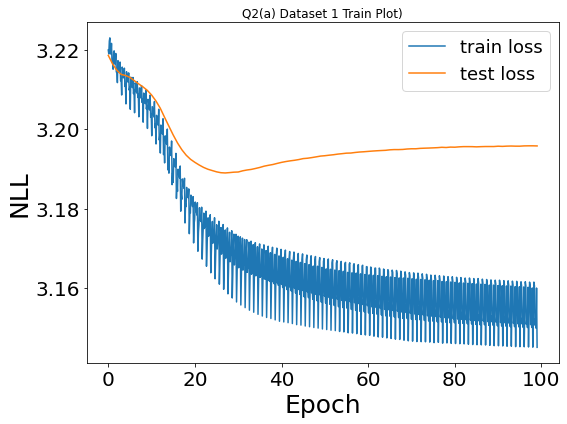

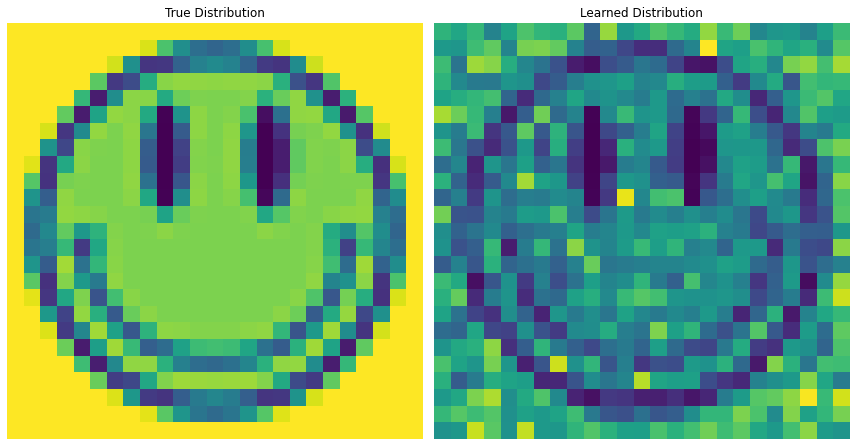

In [7]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 5.3032


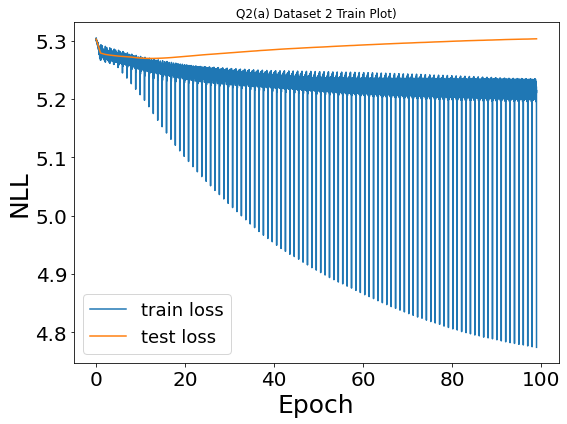

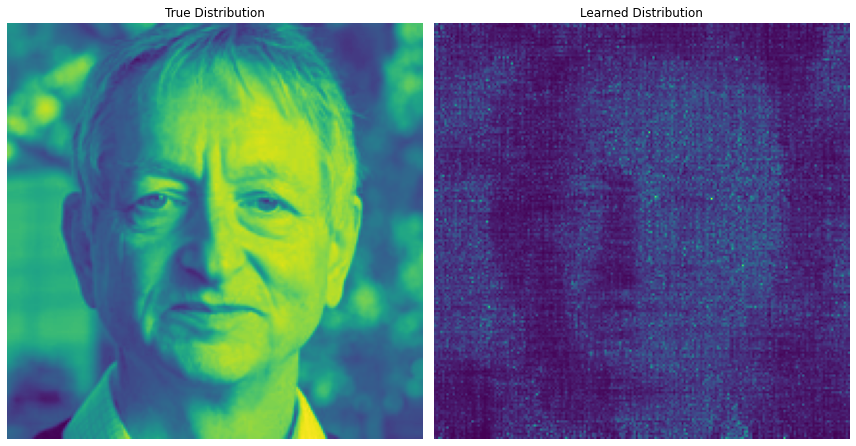

In [8]:
  q1_save_results(2, 'a', q1_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

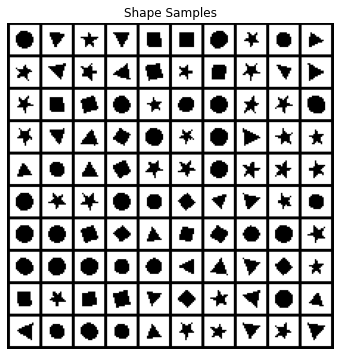

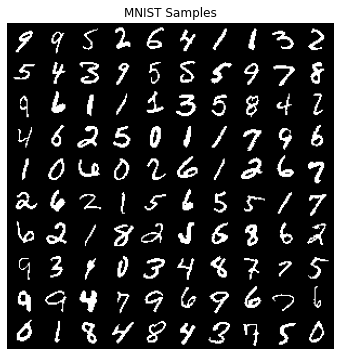

In [9]:
visualize_q1b_data(1)
visualize_q1b_data(2)
# you can access data with get_data_q1_b(dset_type=1)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [14]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    batch_losses = []
    epoch_losses = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train = torch.from_numpy(train_data)
    test = torch.from_numpy(test_data)

    model = MADE(image_shape[0] * image_shape[1], image_shape[0] * image_shape[1], 3, 64, 1).to(device)

    N_EPOCH = 100
    BATCH_SIZE = 1024

    def collate_fn(x):
        flatten_picture = [sample[0].float().flatten() for sample in x]
        return torch.stack(flatten_picture).to(device)

    train_dataset = TensorDataset(train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    test_dataset = TensorDataset(test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    opt = torch.optim.Adam(model.parameters(), 1e-3)

    for n_epoch in range(N_EPOCH):
        # valid_part
        model.eval()
        eval_losses = []

        for batch in test_loader:
            predictions = model(batch)
            loss = F.binary_cross_entropy(torch.sigmoid(predictions.squeeze()), batch)

            eval_losses.append(loss.data.item())

        epoch_losses.append(np.sum(eval_losses) / len(test_loader))

        # train_part
        model.train()

        for batch in train_loader:
            predictions = model(batch)
            loss = F.binary_cross_entropy(torch.sigmoid(predictions.squeeze()), batch)
            
            opt.zero_grad()
            loss.backward()
            opt.step()

            batch_losses.append(loss.data.item())

    # Making probas

    model.eval()
    n = 100
    x = torch.empty(n, image_shape[0] * image_shape[1], device=device)

    for i in range(image_shape[0] * image_shape[1]):
        pred = torch.sigmoid(model(x).squeeze())
        x[:, i] = torch.rand(n, device=device) < pred[:, i]

    return batch_losses, epoch_losses, x.reshape(n, image_shape[0], image_shape[1], 1).cpu().numpy()

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.1420


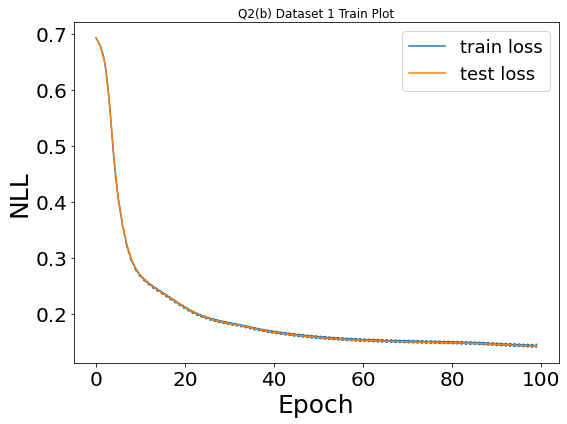

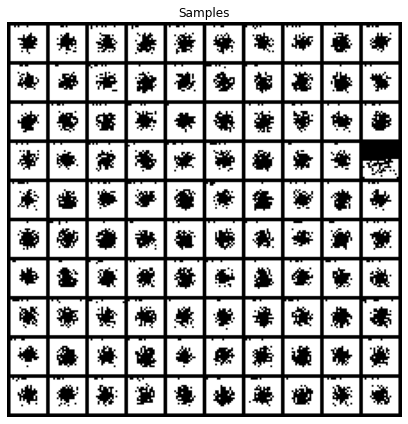

In [15]:
q1_save_results(1, 'b', q1_b)

Final Test Loss: 0.1989


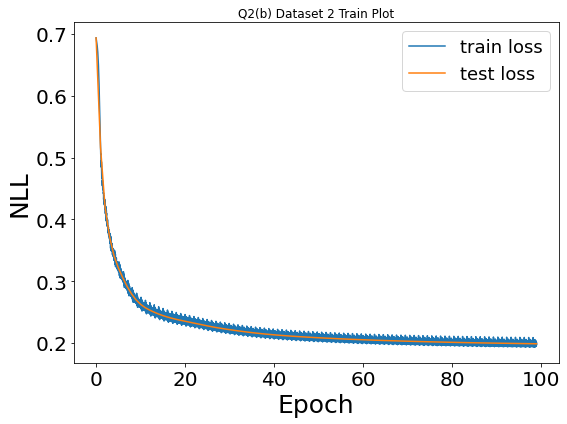

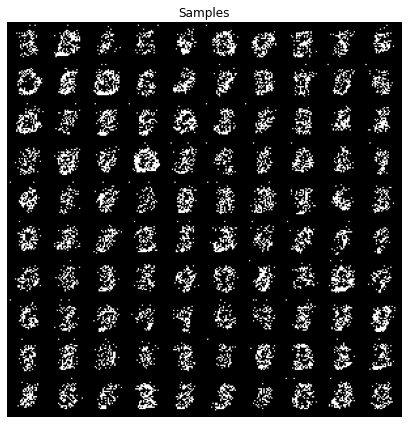

In [16]:
q1_save_results(2, 'b', q1_b)